# Прогнозирование конечных свойств новых материалов (композиционных материалов) - часть 3

**Цель проекта**: сократить количество проводимых испытаний, а также пополнить базу данных материалов возможными новыми характеристиками материалов, и цифровыми двойниками новых композитов. Необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов.

**Исходные данные**: данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). 

Данные со свойствами композитов состоят из 2 файлов:

- `X_bp`
- `X_nup`

**Описание**:

Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т.е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. 

Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента).

##  Загрузка данных и библиотек

Подгрузим библиотеки, требуемые для выполнения проекта:

In [120]:
# Блок импорта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
import re
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Подготовка выборок
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import  make_scorer

# Для нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, ReLU
from sklearn.model_selection import train_test_split
from keras.metrics import MeanSquaredError
from keras import backend as K
from keras.optimizers import adam_v2
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.dummy import DummyRegressor

# Печать жирного шрифта
class color:         
    BOLD = '\033[1m'
    END = '\033[0m'
    
# Переменные
RANDOM_STATE = 4122022

In [9]:
# Вызовем файлы с данными, сохраненными в первой части этой работы:
    
df_1_s = pd.read_csv("E:\df_1_s.csv", index_col=0)

Так как разведочный анализ и предобработка данных была сделана в предыдущей части работы, пропустим эту часть.

In [10]:
# Выведем первые пять строк
df_1_s.head(5).T

,0,1,2,3,4
соотношение матрица-наполнитель,0.282131,0.282131,0.282131,0.282131,0.457857
"плотность, кг/м3",0.626533,0.626533,0.626533,0.626533,0.626533
"модуль упругости, гпа",0.385679,0.385679,0.385679,0.385679,0.393150
"количество отвердителя, м.%",0.067654,0.178021,0.177469,0.613972,0.519387
"содержание эпоксидных групп,%_2",0.427467,0.506535,1.000000,0.373167,0.427467
"температура вспышки, с_2",0.000000,0.589311,0.589311,0.638420,0.589311
"поверхностная плотность, г/м2",0.149682,0.149682,0.149682,0.149682,0.149682
"модуль упругости при растяжении, гпа",0.319194,0.319194,0.319194,0.319194,0.319194
"прочность при растяжении, мпа",0.698235,0.698235,0.698235,0.698235,0.698235
"потребление смолы, г/м2",0.488979,0.488979,0.488979,0.488979,0.488979


## Обучение нейронной сети для рекамендации признака "Соотношение матрица-наполнитель"

### Разбивка данных на выборки

In [15]:
# Создадим датафрейм признаков для данных
print(df_1_s.shape)
    
X = df_1_s.drop("соотношение матрица-наполнитель", axis = 1) 
print(X.shape)  
print('-----------------------------------------------------------------------------------------------------------------')

(1023, 13)
(1023, 12)
-----------------------------------------------------------------------------------------------------------------


In [16]:
# Выделим целевой признак
y = df_1_s["соотношение матрица-наполнитель"]
print(y.shape) 

(1023,)


In [17]:
# Разделим в соотношении 70:30, используем функцию train_test_split():

x_train, x_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
print('Общее количество объектов:', df_1_s.shape[0])
print('Обучающая выборка X_train:',  x_train.shape[0])
print('Тестовая выборка X_test:',  x_test.shape[0])

Общее количество объектов: 1023
Обучающая выборка X_train: 716
Тестовая выборка X_test: 307


### Обучение нейронной сети

Напишем нейронную сеть, которая будет рекомендовать "Соотношение матрица-наполнитель"

In [124]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(x_train, Y_train)
predicted = model_dummy.predict(x_test)  
scores = mean_squared_error(Y_test, predicted)
print(color.BOLD + ' DummyRegressor'+':'+ color.END)
print('MSE модели: ', round(scores, 4))

 DummyRegressor:
MSE модели:  0.0295


In [157]:
model_80 = Sequential()
model_80.add(Dense(64, input_dim=12, activation='relu'))


model_80.add(Dense(64, activation='relu'))
model_80.add(Dense(32, activation='relu'))
model_80.add(Dense(1))
model_80.compile(loss='mean_squared_error', optimizer=adam_v2.Adam(learning_rate=1e-3), metrics=['mean_squared_error'])

In [158]:
model_80.compile(loss='mean_squared_error', optimizer=adam_v2.Adam(learning_rate=1e-3), metrics=['mean_squared_error'])
history = model_80.fit(x_train, Y_train, validation_data = (x_test,Y_test), epochs=100, batch_size = 60)

Epoch 1/100
12/12 [==============================] - 1s 40ms/step - loss: 0.2847 - mean_squared_error: 0.2847 - val_loss: 0.2588 - val_mean_squared_error: 0.2588
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2161 - mean_squared_error: 0.2161 - val_loss: 0.1819 - val_mean_squared_error: 0.1819
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.0987 - val_mean_squared_error: 0.0987
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 7/100
12/12 [============

In [159]:
model_80.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_470 (Dense)           (None, 64)                832       
                                                                 
 dense_471 (Dense)           (None, 64)                4160      
                                                                 
 dense_472 (Dense)           (None, 32)                2080      
                                                                 
 dense_473 (Dense)           (None, 1)                 33        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


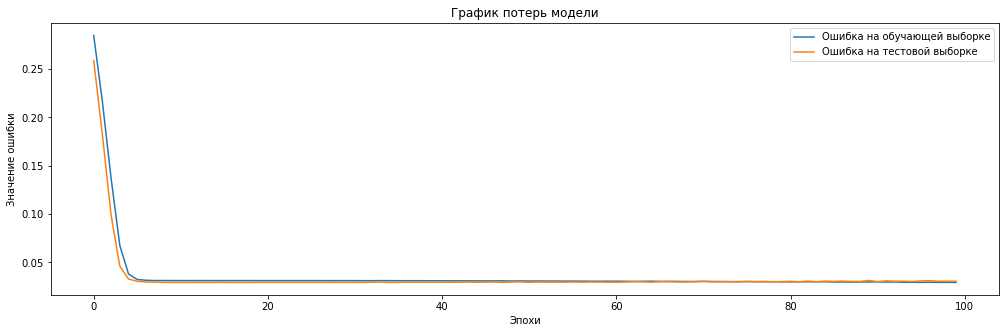

In [160]:
# Посмотрим на график потерь на тренировочной и тестовой выборках
def model_loss_plot(model_hist1):
    plt.figure(figsize = (17,5))
    plt.plot(model_hist1.history['loss'],
             label = 'ошибка на обучающей выборке')
    plt.plot(model_hist1.history['val_loss'],
            label = 'ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.ylabel('Значение ошибки')
    plt.xlabel('Эпохи')
    plt.legend(['Oшибка на обучающей выборке', 'Ошибка на тестовой выборке'], loc='best')
    plt.show()
model_loss_plot(history)

10/10 [==============================] - 0s 3ms/step


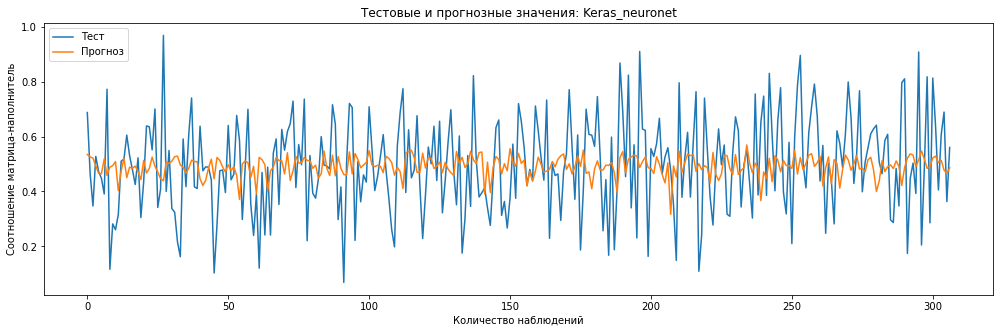

In [161]:
# Зададим функцию для визуализации факт/прогноз для результатов моделей
# Посмотрим на график результата работы модели
def actual_and_predicted_plot(orig, predict, var, model_name):    
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label = 'Тест')
    plt.plot(predict, label = 'Прогноз')
    plt.legend(loc = 'best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()
actual_and_predicted_plot(Y_test.values, model_80.predict(x_test.values), 'Cоотношение матрица-наполнитель', 'Keras_neuronet')

10/10 [==============================] - 0s 3ms/step


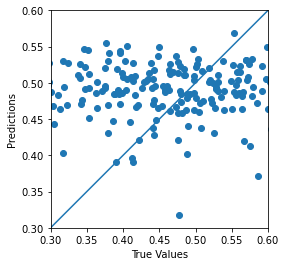

In [164]:
test_predictions = model_80.predict(x_test).flatten()

a = plt.axes(aspect = 'equal')
plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0.3, 0.6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)